In [1]:
"""
 This sample shows how to use OpenCV for format conversion and display.
 The following points will be demonstrated in this sample code:
 - Initialize StApi
 - Connect to camera
 - Register and use callback function with StApi
 - Acquire image data via callback class function
 - Copy image data for OpenCV
 - Convert Bayer image format to RGB using OpenCV
 - Preview image using OpenCV
 Note: opencv-python and numpy packages are required:
    pip install numpy
    pip install opencv-python
"""

import cv2
import threading
import numpy as np
import stapipy as st
import time

# Image scale when displaying using OpenCV.
DISPLAY_RESIZE_FACTOR = 0.3


class CMyCallback:
    """
    Class that contains a callback function.
    """

    def __init__(self):
        self._image = None
        self._lock = threading.Lock()

    @property
    def image(self):
        duplicate = None
        self._lock.acquire()
        if self._image is not None:
            duplicate = self._image.copy()
        self._lock.release()
        return duplicate

    def datastream_callback(self, handle=None, context=None):
        """
        Callback to handle events from DataStream.

        :param handle: handle that trigger the callback.
        :param context: user data passed on during callback registration.
        """
        st_datastream = handle.module
        if st_datastream:
            with st_datastream.retrieve_buffer() as st_buffer:
                # Check if the acquired data contains image data.
                if st_buffer.info.is_image_present:
                    # Create an image object.
                    st_image = st_buffer.get_image()

                    # Check the pixelformat of the input image.
                    pixel_format = st_image.pixel_format
                    pixel_format_info = st.get_pixel_format_info(pixel_format)

                    # Only mono or bayer is processed.
                    if not(pixel_format_info.is_mono or
                           pixel_format_info.is_bayer):
                        return

                    # Get raw image data.
                    data = st_image.get_image_data()

                    # Perform pixel value scaling if each pixel component is
                    # larger than 8bit. Example: 10bit Bayer/Mono, 12bit, etc.
                    if pixel_format_info.each_component_total_bit_count > 8:
                        nparr = np.frombuffer(data, np.uint16)
                        division = pow(2, pixel_format_info
                                       .each_component_valid_bit_count - 8)
                        nparr = (nparr / division).astype('uint8')
                    else:
                        nparr = np.frombuffer(data, np.uint8)

                    # Process image for display.
                    nparr = nparr.reshape(st_image.height, st_image.width, 1)

                    # Perform color conversion for Bayer.
                    if pixel_format_info.is_bayer:
                        bayer_type = pixel_format_info.get_pixel_color_filter()
                        if bayer_type == st.EStPixelColorFilter.BayerRG:
                            nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_RG2RGB)
                        elif bayer_type == st.EStPixelColorFilter.BayerGR:
                            nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_GR2RGB)
                        elif bayer_type == st.EStPixelColorFilter.BayerGB:
                            nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_GB2RGB)
                        elif bayer_type == st.EStPixelColorFilter.BayerBG:
                            nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_BG2RGB)

                    # Resize image and store to self._image.
                    nparr = cv2.resize(nparr, None,
                                       fx=DISPLAY_RESIZE_FACTOR,
                                       fy=DISPLAY_RESIZE_FACTOR)
                    self._lock.acquire()
                    self._image = nparr
                    self._lock.release()

In [4]:

if __name__ == "__main__":
    my_callback = CMyCallback()
    cb_func = my_callback.datastream_callback
    try:
        # Initialize StApi before using.
        st.initialize()

        # Create a system object for device scan and connection.
        st_system = st.create_system()

        # Connect to first detected device.
        st_device = st_system.create_first_device()

        # Display DisplayName of the device.
        print('Device=', st_device.info.display_name)

        # Create a datastream object for handling image stream data.
        st_datastream = st_device.create_datastream()

        # Register callback for datastream
        callback = st_datastream.register_callback(cb_func)

        # Start the image acquisition of the host (local machine) side.
        st_datastream.start_acquisition()

        # Start the image acquisition of the camera side.
        st_device.acquisition_start()

        print("To terminate, focus on the OpenCV window and press any key.")
        while True:
            output_image = my_callback.image
            if output_image is not None:
                cv2.imshow('image', output_image)
            key_input = cv2.waitKey(1)
            if key_input != -1:
                break
            time.sleep(1)

        # Stop the image acquisition of the camera side
        st_device.acquisition_stop()

        # Stop the image acquisition of the host side
        st_datastream.stop_acquisition()

    except Exception as exception:
        print(exception)


-1004 = GCInitLib()


In [6]:
"""
 This sample shows the basic operation of using StApi for connecting,
 controlling, and acquiring image from camera.
 The following points will be demonstrated in this sample code:
 - Initialize StApi
 - Connect to camera
 - Acquire image data (with waiting in main thread)
"""

import stapipy as st
import time
import matplotlib.pyplot as plt

# Number of images to grab
number_of_images_to_grab = 1

try:
    # Initialize StApi before using.
    st.initialize()

    # Create a system object for device scan and connection.
    st_system = st.create_system()

    # Connect to first detected device.
    st_device = st_system.create_first_device()

    # Display DisplayName of the device.
    print('Device=', st_device.info.display_name)

    # Create a datastream object for handling image stream data.
    st_datastream = st_device.create_datastream()

    # Start the image acquisition of the host (local machine) side.
    st_datastream.start_acquisition(number_of_images_to_grab)

    # Start the image acquisition of the camera side.
    st_device.acquisition_start()

    # A while loop for acquiring data and checking status
    while st_datastream.is_grabbing:
        # Create a localized variable st_buffer using 'with'
        # Warning: if st_buffer is in a global scope, st_buffer must be
        #          assign to None to allow Garbage Collector release the buffer
        #          properly.
        with st_datastream.retrieve_buffer() as st_buffer:
            # Check if the acquired data contains image data.
            if st_buffer.info.is_image_present:
                # Create an image object.
                st_image = st_buffer.get_image()
                # Display the information of the acquired image data.
                print("BlockID={0} Size={1} x {2} First Byte={3}".format(
                      st_buffer.info.frame_id,
                      st_image.width, st_image.height,
                      st_image.get_image_data()[0]))
            else:
                # If the acquired data contains no image data.
                print("Image data does not exist.")

    # Stop the image acquisition of the camera side
    st_device.acquisition_stop()

    # Stop the image acquisition of the host side
    st_datastream.stop_acquisition()

except Exception as exception:
    print(exception)


-1004 = GCInitLib()


In [1]:
import stapipy as st
import time
import matplotlib.pyplot as plt

# Number of images to grab
number_of_images_to_grab = 0

# Initialize StApi before using.
st.initialize()

# Create a system object for device scan and connection.
st_system = st.create_system()

# Connect to first detected device.
st_device = st_system.create_first_device()

# Display DisplayName of the device.
print('Device=', st_device.info.display_name)

# Create a datastream object for handling image stream data.
st_datastream = st_device.create_datastream()

# Start the image acquisition of the host (local machine) side.
st_datastream.start_acquisition()
    

Device= STC-MCS500POE(21FH158)


In [3]:
st_datastream.start_acquisition()

In [2]:
st_datastream.stop_acquisition()

Time : 0.1296522617340088


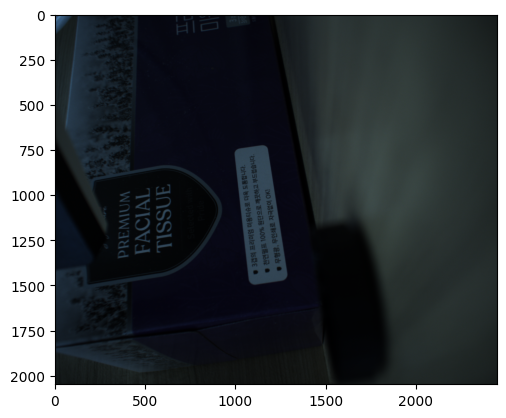

In [7]:
import numpy as np

import cv2

start = time.time()

# Start the image acquisition of the camera side.
st_device.acquisition_start()

# if st_datastream.is_grabbing:
with st_datastream.retrieve_buffer() as st_buffer:
    # Check if the acquired data contains image data.
    if st_buffer.info.is_image_present:
        # Create an image object.
        st_image = st_buffer.get_image()
        
        pixel_format = st_image.pixel_format
        pixel_format_info = st.get_pixel_format_info(pixel_format)

        # Only mono or bayer is processed.
        # if not(pixel_format_info.is_mono or
        #        pixel_format_info.is_bayer):
        #     return

        # Get raw image data.
        data = st_image.get_image_data()

        # Perform pixel value scaling if each pixel component is
        # larger than 8bit. Example: 10bit Bayer/Mono, 12bit, etc.
        if pixel_format_info.each_component_total_bit_count > 8:
            nparr = np.frombuffer(data, np.uint16)
            division = pow(2, pixel_format_info
                           .each_component_valid_bit_count - 8)
            nparr = (nparr / division).astype('uint8')
        else:
            nparr = np.frombuffer(data, np.uint8)

        # Process image for display.
        nparr = nparr.reshape(st_image.height, st_image.width, 1)

        # Perform color conversion for Bayer.
        if pixel_format_info.is_bayer:
            bayer_type = pixel_format_info.get_pixel_color_filter()
            if bayer_type == st.EStPixelColorFilter.BayerRG:
                nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_RG2RGB)
            elif bayer_type == st.EStPixelColorFilter.BayerGR:
                nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_GR2RGB)
            elif bayer_type == st.EStPixelColorFilter.BayerGB:
                nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_GB2RGB)
            elif bayer_type == st.EStPixelColorFilter.BayerBG:
                nparr = cv2.cvtColor(nparr, cv2.COLOR_BAYER_BG2RGB)
                            
    else:
        # If the acquired data contains no image data.
        print("Image data does not exist.")

# Stop the image acquisition of the camera side
st_device.acquisition_stop()

end = time.time()

plt.imshow(nparr[:,:,::-1])

print("Time :", end-start)

In [8]:
def edit_ExposureTime(st_device, new_value):
    nodemap = st_device.remote_port.nodemap
    node = nodemap.get_node("ExposureTime")
    if not node.is_writable:
        return
    if node.principal_interface_type == st.EGCInterfaceType.IFloat:
        node_value = st.PyIFloat(node)
    elif node.principal_interface_type == st.EGCInterfaceType.IInteger:
        node_value = st.PyIInteger(node)
        
    if node.principal_interface_type == st.EGCInterfaceType.IFloat:
        new_numeric_value = float(new_value)
    else:
        new_numeric_value = int(new_value)
    if node_value.min <= new_numeric_value <= node_value.max:
        node_value.value = new_numeric_value
        
edit_ExposureTime(st_device, 10000)